In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Switch values if necessary 1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# 26 11 2021
#Dist_prism_12 = 1.03688797895733
#Dist_prism_13 = 0.822536135483593
#Dist_prism_23 = 0.8783765747673403
#Dist_GPS_12 = 0.7828618536473139
#Dist_GPS_13 = 0.8394208131018045
#Dist_GPS_23 = 0.5176447366930409

# 31 01 2022
#Dist_prism_12 = 1.038854051807371
#Dist_prism_13 = 0.8202157646292075
#Dist_prism_23 = 0.879788333022114
#Dist_GPS_12 = 0.7830826912858335
#Dist_GPS_13 = 0.8418404054627937
#Dist_GPS_23 = 0.5172558618541933
     
# 03 02 2022
#Dist_prism_12 = 1.0403741344089559
#Dist_prism_13 = 0.8239475424257701
#Dist_prism_23 = 0.8766711748547112
#Dist_GPS_12 = 0.781661929058067
#Dist_GPS_13 = 0.8353981332464246
#Dist_GPS_23 = 0.5174987476948135

# 17 02 2022 / 24 02 2022
#Dist_prism_12 = 0.8882613537922258
#Dist_prism_13 = 0.8262903370535766
#Dist_prism_23 = 1.0377436460567973
#Dist_GPS_12 = 0.7809786915630756
#Dist_GPS_13 = 0.8378323585433202
#Dist_GPS_23 = 0.5191788936274444   

# 07 03 2022
#Dist_prism_12 = 0.8832836583456264
#Dist_prism_13 = 0.8247449387008166
#Dist_prism_23 = 1.039409793600046
#Dist_GPS_12 = 0.7781099344563802
#Dist_GPS_13 = 0.8431026980109139
#Dist_GPS_23 = 0.5157221841320069

# 12 03 2022
#Dist_prism_12 = 0.8860734460339026
#Dist_prism_13 = 0.8303896290142598
#Dist_prism_23 = 1.0393117663247973
#Dist_GPS_12 = 0.7829424296161074
#Dist_GPS_13 = 0.8415176433032493
#Dist_GPS_23 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363
#Dist_GPS_12 = 0.7829081036179948
#Dist_GPS_13 = 0.8424633975958637
#Dist_GPS_23 = 0.5165807364575292

# 31 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363
#Dist_GPS_12 = 0.7829081036179948
#Dist_GPS_13 = 0.8424633975958637
#Dist_GPS_23 = 0.5165807364575292

# 27 04 2022
#Dist_prism_12 = 0.8856608085851714
#Dist_prism_13 = 0.8264452483880412
#Dist_prism_23 = 1.0384219210289538
#Dist_GPS_12 = 0.7809547832390561
#Dist_GPS_13 = 0.8259590286006459
#Dist_GPS_23 = 0.5191274645630007  

# 27 04 2022 soir
Dist_prism_12 = 0.8868846942534616
Dist_prism_13 = 0.829169129877633
Dist_prism_23 = 1.0387571594276301
Dist_GPS_12 = 0.7837749633840095
Dist_GPS_13 = 0.8323125081688734
Dist_GPS_23 = 0.5187055120945835
  

In [3]:
tfuu = importlib.reload(tfuu)
path = "./data/prediction/TS/20220427_soir/"
prefix = "GP-10-20"
P1 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_1.csv"))
P2 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_2.csv"))
P3 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_3.csv"))

path_gps = "./data/gps/20220427_soir/"
G1 = np.array(tfuu.read_gps_point_processed(path_gps+"gpsfront.csv"))
G2 = np.array(tfuu.read_gps_point_processed(path_gps+"gpsback.csv"))
G3 = np.array(tfuu.read_gps_point_processed(path_gps+"gpsmiddle.csv"))

1651107901.4522133


<IPython.core.display.Javascript object>


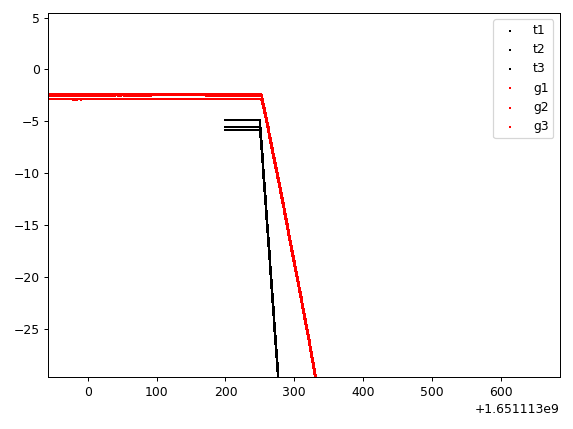

In [16]:
%matplotlib notebook
print(P1[0,0]-G1[0,0])
plt.figure(0)
coord = -1
start = 0
startgps = 0
stop = -1
stopgps = -1
#origin = -1645055982.5  #17 02 2022
#origin = -1645660780  #24 02 2022
#origin = -1646697587  #07 03 2022
#origin = -1647043185  #12 03 2022
#origin = -1647215980  #14 03 2022
#origin = -1647388785  #16 03 2022
#origin = -1648684645  #31 03 2022 -1
#origin = -1648685000  #31 03 2022 -2
#origin = -1651017650  #27 04 2022 
origin = -1651104022  #27 04 2022 soir

origin_x_g = G1[0,1]
origin_y_g = G1[0,2]
origin_z_g = G1[0,3]
offsettrimble = -0
plt.scatter(P1[start:stop,coord+1], -P1[start:stop,coord+2]+offsettrimble, label="t1", marker="+", s = 1, color="black")
plt.scatter(P2[start:stop,coord+1], -P2[start:stop,coord+2]+offsettrimble, label="t2", marker="+", s = 1, color="black")
plt.scatter(P3[start:stop,coord+1], -P3[start:stop,coord+2]+offsettrimble, label="t3", marker="+", s = 1, color="black")

plt.scatter(G1[startgps:stopgps,coord+1]-origin, G1[startgps:stopgps,coord+2]-origin_x_g, label="g1", marker="+", s = 1, color="red")
plt.scatter(G2[startgps:stopgps,coord+1]-origin, G2[startgps:stopgps,coord+2]-origin_x_g, label="g2", marker="+", s = 1, color="red")
plt.scatter(G3[startgps:stopgps,coord+1]-origin, G3[startgps:stopgps,coord+2]-origin_x_g, label="g3", marker="+", s = 1, color="red")


ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
plt.show()    

In [17]:
#time_offset = -1645055982.5 #17 02 2022
#time_offset = -1645660780  #24 02 2022
#time_offset = -1646697587 #07 03 2022
#time_offset = -1647043185 #12 03 2022
#time_offset = -1647215980  #14 03 2022
#time_offset = -1647388785  #16 03 2022
#time_offset = -1648684645   #31 03 2022 -1
#time_offset = -1648685000  #31 03 2022 -2
#time_offset = -1651017650  #27 04 2022 
time_offset = -1651104022  #27 04 2022 soir

G1t = []
G2t = []
G3t = []
for i,j,k in zip(G1, G2, G3):
    G1t.append(i)
    G2t.append(j)
    G3t.append(k)
    G1t[-1][0] = G1t[-1][0] - time_offset
    G2t[-1][0] = G2t[-1][0] - time_offset
    G3t[-1][0] = G3t[-1][0] - time_offset

G1t = np.array(G1t)
G2t = np.array(G2t)
G3t = np.array(G3t)

<IPython.core.display.Javascript object>


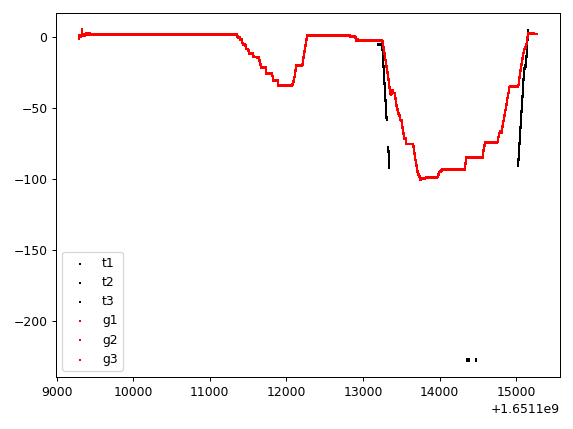

In [18]:
%matplotlib notebook
plt.figure(0)
coord = -1
start = 0
stop = -1
origin_x_gt = G1t[0,1]
origin_y_gt = G1t[0,2]
origin_z_gt = G1t[0,3]
plt.scatter(P1[start:stop,coord+1], -P1[start:stop,coord+2], label="t1", marker="+", s = 1, color="black")
plt.scatter(P2[start:stop,coord+1], -P2[start:stop,coord+2], label="t2", marker="+", s = 1, color="black")
plt.scatter(P3[start:stop,coord+1], -P3[start:stop,coord+2], label="t3", marker="+", s = 1, color="black")

plt.scatter(G1t[start:stop,coord+1], G1t[start:stop,coord+2]-origin_x_gt, label="g1", marker="+", s = 1, color="red")
plt.scatter(G2t[start:stop,coord+1], G2t[start:stop,coord+2]-origin_x_gt, label="g2", marker="+", s = 1, color="red")
plt.scatter(G3t[start:stop,coord+1], G3t[start:stop,coord+2]-origin_x_gt, label="g3", marker="+", s = 1, color="red")

ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
plt.show()    

In [19]:
dist_prism = []
origin = P1[0,0]
for i in range(0,len(P1[:,0])):
    dp1 = abs(np.linalg.norm(P1[i,1:4]-P2[i,1:4])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(P1[i,1:4]-P3[i,1:4])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(P3[i,1:4]-P2[i,1:4])-Dist_prism_23)*1000
    dist_prism.append(np.array([P1[i,0]-origin, dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

path_gps = "./data/gps/20220427_soir/"
gps_dist_12 = np.array(tfuu.read_gps_distance_processed(path_gps+"gps12_distance.csv"))
gps_dist_13 = np.array(tfuu.read_gps_distance_processed(path_gps+"gps13_distance.csv"))
gps_dist_23 = np.array(tfuu.read_gps_distance_processed(path_gps+"gps23_distance.csv"))

dist_gps = []
#time_offset = -1645055982.5  #17 02 2022
#time_offset = -1645660780  #24 02 2022
#time_offset = -1646697587 #07 03 2022
#time_offset = -1647043185 #12 03 2022 
#time_offset = -1647215980  #14 03 2022
#time_offset = -1647388785  #16 03 2022
#time_offset = -1648684645   #31 03 2022 - 01
#time_offset = -1648685000  #31 03 2022 -2
#time_offset = -1651017650  #27 04 2022 
time_offset = -1651104022  #27 04 2022 soir

for i in P1:
    timestamp = i[0] + time_offset
    ind1, t1 = tfu.findClosest(gps_dist_12[:,0], timestamp)
    ind2, t2 = tfu.findClosest(gps_dist_13[:,0], timestamp)
    ind3, t3 = tfu.findClosest(gps_dist_23[:,0], timestamp)
    if(abs(timestamp-t1)<0.1 and abs(timestamp-t2)<0.1 and abs(timestamp-t3)<0.1):
        dg1 = abs(gps_dist_12[ind1,1]-Dist_GPS_12)*1000
        dg2 = abs(gps_dist_13[ind2,1]-Dist_GPS_13)*1000
        dg3 = abs(gps_dist_23[ind3,1]-Dist_GPS_23)*1000
        dist_gps.append(np.array([i[0]-origin, dg1, dg2, dg3]))
dist_gps = np.array(dist_gps)

Mean inter-prism [mm]:  4.15 9.45 4.44
Std inter-prism [mm]:  7.73 4.25 6.953
Mean inter-GPS [mm]:  20.26 9.21 15.9
Std inter-GPS [mm]:  27.83 9.04 16.32


<IPython.core.display.Javascript object>


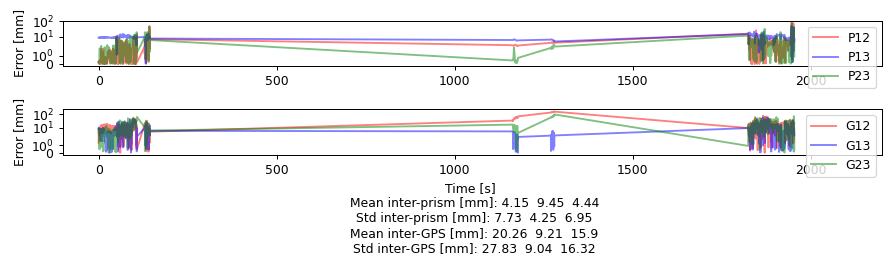

In [22]:
%matplotlib notebook

print("Mean inter-prism [mm]: ", round(np.mean(dist_prism[:,1]),2), round(np.mean(dist_prism[:,2]),2), round(np.mean(dist_prism[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism[:,1]),2), round(np.std(dist_prism[:,2]),2), round(np.std(dist_prism[:,3]),3))
print("Mean inter-GPS [mm]: ", round(np.mean(dist_gps[:,1]),2), round(np.mean(dist_gps[:,2]),2), round(np.mean(dist_gps[:,3]),2))
print("Std inter-GPS [mm]: ", round(np.std(dist_gps[:,1]),2), round(np.std(dist_gps[:,2]),2), round(np.std(dist_gps[:,3]),2))

limitx = [-100, 2200]
plt.figure(figsize=(10,3))
plt.subplot(211)
plt.plot(dist_prism[:,0], dist_prism[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism[:,0], dist_prism[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism[:,0], dist_prism[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
ax.set_xlim(limitx)

plt.subplot(212)
plt.plot(dist_gps[:,0], dist_gps[:,1], label="G12", color="red", alpha=0.5)
plt.plot(dist_gps[:,0], dist_gps[:,2], label="G13", color="blue", alpha=0.5)
plt.plot(dist_gps[:,0], dist_gps[:,3], label="G23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism[:,1]),2)) + "  " + str(round(np.mean(dist_prism[:,2]),2)) + "  " + str(round(np.mean(dist_prism[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism[:,1]),2)) + "  " + str(round(np.std(dist_prism[:,2]),2)) + "  " + str(round(np.std(dist_prism[:,3]),2))
             + "\n Mean inter-GPS [mm]: " + str(round(np.mean(dist_gps[:,1]),2)) + "  " + str(round(np.mean(dist_gps[:,2]),2)) + "  " + str(round(np.mean(dist_gps[:,3]),2))
             + "\n Std inter-GPS [mm]: " + str(round(np.std(dist_gps[:,1]),2)) + "  " + str(round(np.std(dist_gps[:,2]),2)) + "  " + str(round(np.std(dist_gps[:,3]),2)))
ax.set_ylabel("Error [mm]")
ax.set_xlim(limitx)

plt.savefig("./figs/comparison_20220427_soir.jpg")
plt.show()   

In [ ]:
plt.figure(2)
start = 1000
stop = -400
plt.plot(gps_dist_12[start:stop,0], abs(gps_dist_12[start:stop,1]-np.ones_like(gps_dist_12[start:stop,1])*Dist_GPS_12)*1000)
plt.plot(gps_dist_13[start:stop,0], abs(gps_dist_13[start:stop,1]-np.ones_like(gps_dist_13[start:stop,1])*Dist_GPS_13)*1000)
plt.plot(gps_dist_23[start:stop,0], abs(gps_dist_23[start:stop,1]-np.ones_like(gps_dist_23[start:stop,1])*Dist_GPS_23)*1000)